
=== Size 256 x 256 ===
Running naive... time=0.0023s, memory=0.50MB
Running blocked... time=0.0181s, memory=1.02MB
Running strassen... time=0.0021s, memory=1.63MB

Sparse density 0.010... time=0.0006s, memory=0.50MB

Sparse density 0.050... time=0.0006s, memory=0.50MB

Sparse density 0.100... time=0.0007s, memory=0.50MB

=== Size 512 x 512 ===
Running naive... time=0.0287s, memory=2.00MB
Running blocked... time=0.1031s, memory=3.43MB
Running strassen... time=0.0445s, memory=6.50MB

Sparse density 0.010... time=0.0041s, memory=2.00MB

Sparse density 0.050... time=0.0086s, memory=2.00MB

Sparse density 0.100... time=0.0151s, memory=2.00MB

=== Size 1024 x 1024 ===
Running naive... time=0.1108s, memory=8.00MB
Running blocked... time=1.1268s, memory=16.79MB
Running strassen... time=0.1798s, memory=26.00MB

Sparse density 0.010... time=0.0094s, memory=8.00MB

Sparse density 0.050... time=0.0303s, memory=8.00MB

Sparse density 0.100... time=0.0715s, memory=8.00MB

=== Size 2048 x 2048 ===
R

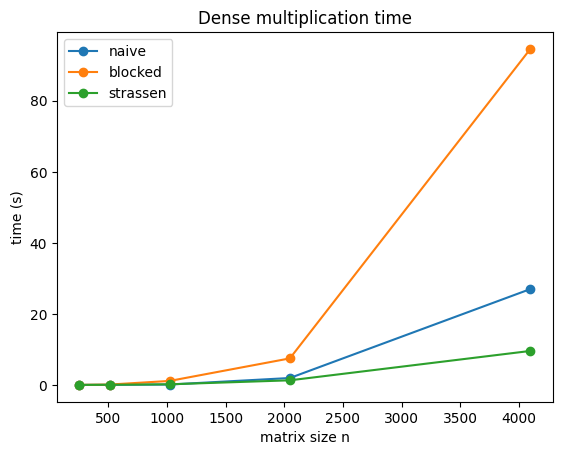

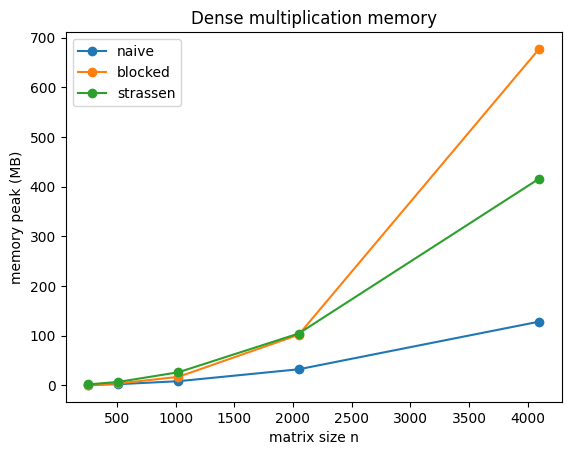

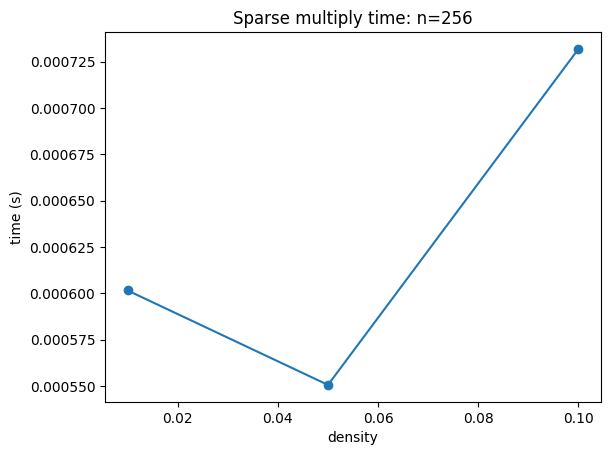

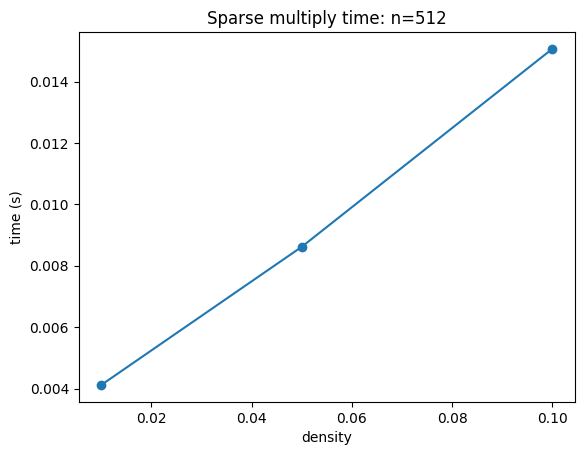

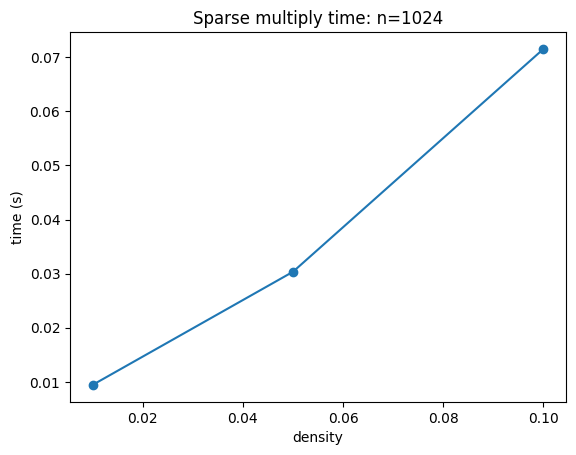

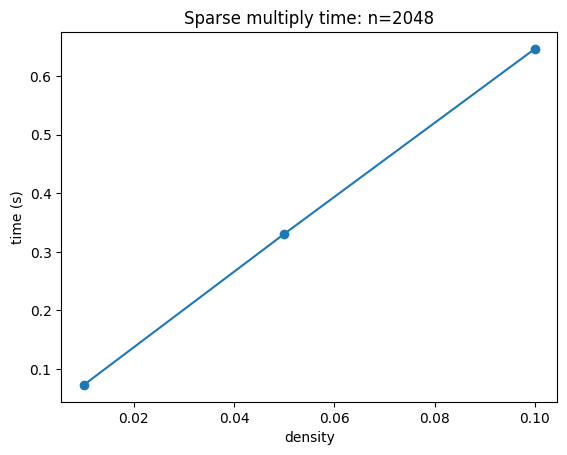

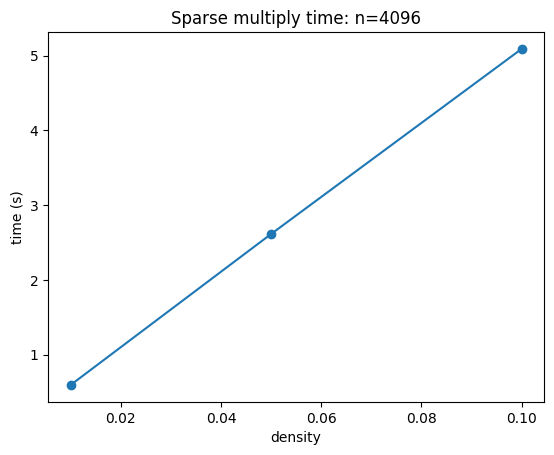

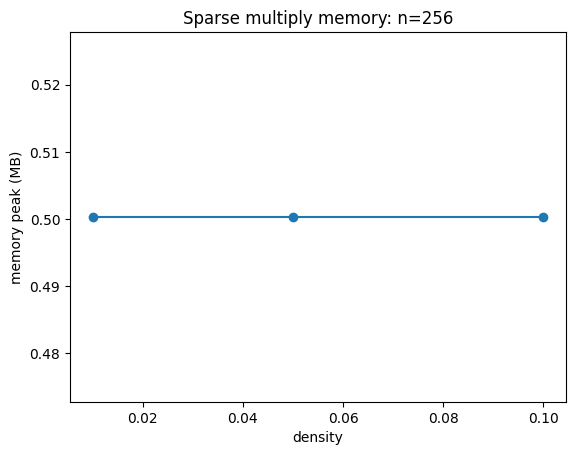

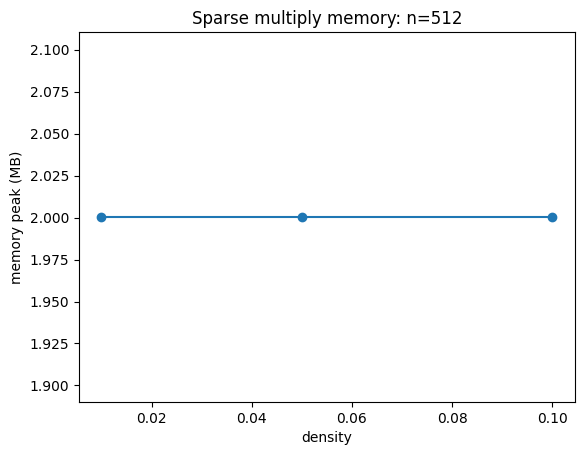

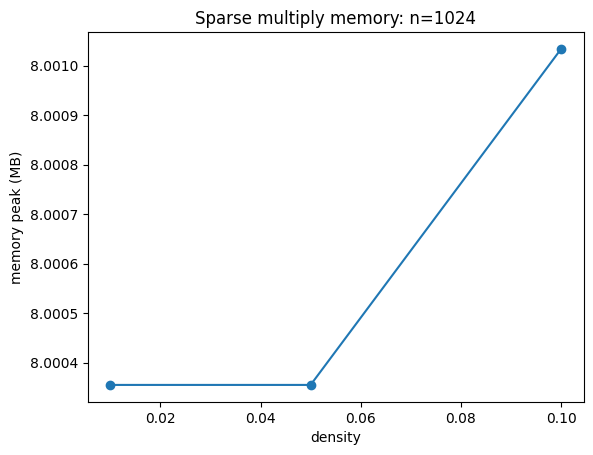

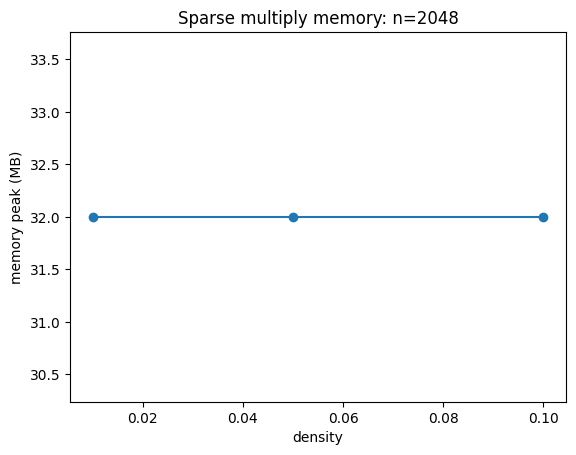

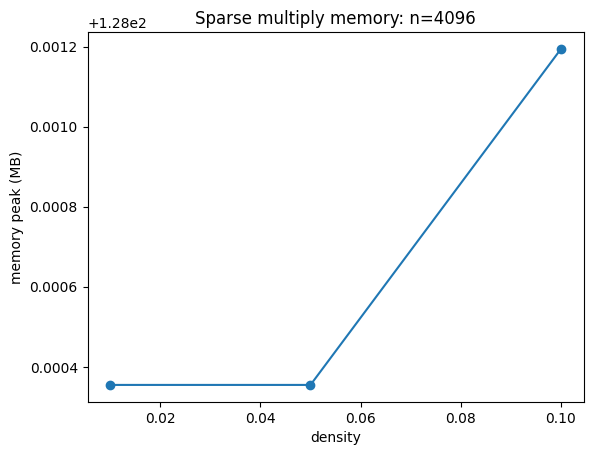

In [19]:
# -*- coding: utf-8 -*-
import time
import numpy as np
import matplotlib.pyplot as plt
import tracemalloc
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

# Numba (solo para naive seguro)
try:
    from numba import njit, prange
    HAS_NUMBA = True
except ImportError:
    HAS_NUMBA = False
    print("Warning: Numba no encontrado. Usando Python puro.")

# Sparse
HAS_SCIPY = False
try:
    import scipy.sparse as sp
    HAS_SCIPY = True
except ImportError:
    HAS_SCIPY = False

# ------------------------
# Algoritmos densos
# ------------------------
if HAS_NUMBA:
    @njit(parallel=True)
    def naive_matmul(A, B):
        n = A.shape[0]
        C = np.zeros((n, n), dtype=A.dtype)
        for i in prange(n):
            for k in range(n):
                for j in range(n):
                    C[i,j] += A[i,k] * B[k,j]
        return C
else:
    def naive_matmul(A,B):
        n = A.shape[0]
        C = np.zeros((n,n), dtype=A.dtype)
        for i in range(n):
            for k in range(n):
                for j in range(n):
                    C[i,j] += A[i,k]*B[k,j]
        return C

# Blocked con ThreadPoolExecutor para paralelismo seguro
def blocked_matmul(A,B,block_size=64,max_workers=4):
    n = A.shape[0]
    C = np.zeros((n,n),dtype=A.dtype)
    bs = block_size

    def mul_block(ii, jj, kk):
        iend = min(ii+bs,n)
        jend = min(jj+bs,n)
        kend = min(kk+bs,n)
        C[ii:iend,jj:jend] += A[ii:iend,kk:kend] @ B[kk:kend,jj:jend]

    tasks = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for ii in range(0,n,bs):
            for jj in range(0,n,bs):
                for kk in range(0,n,bs):
                    tasks.append(executor.submit(mul_block,ii,jj,kk))
        for f in as_completed(tasks):
            pass
    return C

# Strassen
def _pad_to_power_of_two(A,B):
    n = max(A.shape[0],B.shape[0])
    m = 1<<(n-1).bit_length()
    if m==n:
        return A,B,n
    A_p = np.zeros((m,m), dtype=A.dtype)
    B_p = np.zeros((m,m), dtype=B.dtype)
    A_p[:A.shape[0],:A.shape[1]] = A
    B_p[:B.shape[0],:B.shape[1]] = B
    return A_p,B_p,m

def strassen_matmul(A,B,crossover=128):
    assert A.shape==B.shape
    n = A.shape[0]
    if n <= crossover:
        return A@B
    if (n&(n-1)) != 0:
        A_p,B_p,m = _pad_to_power_of_two(A,B)
        C_p = strassen_matmul(A_p,B_p,crossover)
        return C_p[:n,:n]
    mid = n//2
    A11,A12,A21,A22 = A[:mid,:mid],A[:mid,mid:],A[mid:,:mid],A[mid:,mid:]
    B11,B12,B21,B22 = B[:mid,:mid],B[:mid,mid:],B[mid:,:mid],B[mid:,mid:]
    M1 = strassen_matmul(A11+A22,B11+B22,crossover)
    M2 = strassen_matmul(A21+A22,B11,crossover)
    M3 = strassen_matmul(A11,B12-B22,crossover)
    M4 = strassen_matmul(A22,B21-B11,crossover)
    M5 = strassen_matmul(A11+A12,B22,crossover)
    M6 = strassen_matmul(A21-A11,B11+B12,crossover)
    M7 = strassen_matmul(A12-A22,B21+B22,crossover)
    C = np.empty_like(A)
    C[:mid,:mid] = M1+M4-M5+M7
    C[:mid,mid:] = M3+M5
    C[mid:,:mid] = M2+M4
    C[mid:,mid:] = M1-M2+M3+M6
    return C

# ------------------------
# Sparse
# ------------------------
def dense_to_random_sparse(n,density,seed=None):
    rng = np.random.default_rng(seed)
    if HAS_SCIPY:
        return sp.random(n,n,density=density,format='csr',dtype=np.float64,random_state=rng)
    rows,cols,vals=[],[],[]
    for i in range(n):
        for j in range(n):
            if rng.random()<density:
                rows.append(i); cols.append(j); vals.append(rng.random())
    return (n,rows,cols,vals)

def csr_matmul(A_csr,B_dense):
    if HAS_SCIPY:
        return A_csr.dot(B_dense)
    n,rows,cols,vals = A_csr
    from collections import defaultdict
    row_dict=defaultdict(list)
    for r,c,v in zip(rows,cols,vals):
        row_dict[r].append((c,v))
    m=B_dense.shape[1]
    C=np.zeros((n,m))
    for i in range(n):
        for c,v in row_dict.get(i,[]):
            C[i,:]+=v*B_dense[c,:]
    return C

# ------------------------
# Medición con tiempo y memoria
# ------------------------
def run_and_measure(func,*args,warmup=False):
    if warmup: _ = func(*args)
    tracemalloc.start()
    t0 = time.perf_counter()
    result = func(*args)
    t1 = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return {'time_s': t1-t0, 'memory_MB': peak/1024**2, 'result': result}

# ------------------------
# Experimentos
# ------------------------
def run_experiments(sizes,densities,max_time_per_run=25.0,block_size=64):
    results={'dense':defaultdict(dict),'sparse':defaultdict(dict)}
    too_slow_flags={'naive':False,'blocked':False,'strassen':False,'sparse':{}}

    # Wrapper blocked
    def blocked_for_experiment(A,B):
        return blocked_matmul(A,B,block_size)

    for n in sizes:
        print(f"\n=== Size {n} x {n} ===")
        A=np.random.random((n,n))
        B=np.random.random((n,n))

        for method_name,func in [('naive',naive_matmul),
                                 ('blocked',blocked_for_experiment),
                                 ('strassen',strassen_matmul)]:
            if too_slow_flags[method_name]:
                print(f"Skipping {method_name} (too slow).")
                results['dense'][n][method_name]={'skipped':True}
                continue
            print(f"Running {method_name}...",end='',flush=True)
            r=run_and_measure(func,A,B,warmup=True)
            print(f" time={r['time_s']:.4f}s, memory={r['memory_MB']:.2f}MB")
            results['dense'][n][method_name]=r
            if r['time_s']>max_time_per_run:
                print(f" -> {method_name} exceeded time limit. Skipping larger sizes.")
                too_slow_flags[method_name]=True
                results['dense'][n][method_name]['too_slow']=True

        # Sparse
        for density in densities:
            key=(n,density)
            if too_slow_flags['sparse'].get(density,False):
                print(f"Skipping sparse density {density:.3f} (too slow).")
                results['sparse'][key]={'skipped':True}
                continue
            print(f"\nSparse density {density:.3f}...",end='',flush=True)
            A_csr=dense_to_random_sparse(n,density,seed=42)
            if HAS_SCIPY:
                r=run_and_measure(lambda a,b: a.dot(b),A_csr,B,warmup=True)
            else:
                r=run_and_measure(csr_matmul,A_csr,B,warmup=True)
            print(f" time={r['time_s']:.4f}s, memory={r['memory_MB']:.2f}MB")
            results['sparse'][key]=r
            if r['time_s']>max_time_per_run:
                print(f" -> Sparse density {density:.3f} exceeded limit. Skipping larger sizes.")
                too_slow_flags['sparse'][density]=True
    return results

# ------------------------
# Reporte
# ------------------------
def print_summary(results):
    print("\n=== SUMMARY ===")
    for n,rec in sorted(results['dense'].items()):
        print(f"\nSize {n}:")
        for method in ['naive','blocked','strassen']:
            info=rec.get(method,{} )
            if 'time_s' in info:
                print(f" {method:8s} time={info['time_s']:.4f}s, memory={info['memory_MB']:.2f}MB")
            else:
                print(f" {method:8s} skipped/error")
    print("\nSparse results:")
    for (n,density),info in results['sparse'].items():
        if 'time_s' in info:
            print(f" n={n} d={density:.3f} time={info['time_s']:.4f}s, memory={info['memory_MB']:.2f}MB")
        else:
            print(f" n={n} d={density:.3f} skipped/error")

def plot_results(results,out_prefix="bench"):
    sizes = sorted(results['dense'].keys())
    methods = ['naive','blocked','strassen']

    # --- Dense time plot ---
    fig,ax = plt.subplots()
    for method in methods:
        times = [results['dense'][n].get(method,{}).get('time_s',float('nan')) for n in sizes]
        ax.plot(sizes,times,marker='o',label=method)
    ax.set_xlabel("matrix size n")
    ax.set_ylabel("time (s)")
    ax.set_title("Dense multiplication time")
    ax.legend()
    fig.savefig(f"{out_prefix}_dense_time_vs_n.png")
    print(f"Saved {out_prefix}_dense_time_vs_n.png")

    # --- Dense memory plot ---
    fig,ax = plt.subplots()
    for method in methods:
        mems = [results['dense'][n].get(method,{}).get('memory_MB',float('nan')) for n in sizes]
        ax.plot(sizes,mems,marker='o',label=method)
    ax.set_xlabel("matrix size n")
    ax.set_ylabel("memory peak (MB)")
    ax.set_title("Dense multiplication memory")
    ax.legend()
    fig.savefig(f"{out_prefix}_dense_memory_vs_n.png")
    print(f"Saved {out_prefix}_dense_memory_vs_n.png")

    # --- Sparse time plots ---
    sparse_map = {}
    for (n,d),info in results['sparse'].items():
        sparse_map.setdefault(n,[]).append((d,info.get('time_s',float('nan'))))
    for n,lst in sparse_map.items():
        lst_sorted = sorted(lst,key=lambda x:x[0])
        ds = [x[0] for x in lst_sorted]
        ts = [x[1] for x in lst_sorted]
        fig,ax = plt.subplots()
        ax.plot(ds,ts,marker='o')
        ax.set_xlabel("density")
        ax.set_ylabel("time (s)")
        ax.set_title(f"Sparse multiply time: n={n}")
        fig.savefig(f"{out_prefix}_sparse_n{n}.png")
        print(f"Saved {out_prefix}_sparse_n{n}.png")

    # --- Sparse memory plots ---
    sparse_map_mem = {}
    for (n,d),info in results['sparse'].items():
        sparse_map_mem.setdefault(n,[]).append((d,info.get('memory_MB',float('nan'))))
    for n,lst in sparse_map_mem.items():
        lst_sorted = sorted(lst,key=lambda x:x[0])
        ds = [x[0] for x in lst_sorted]
        ms = [x[1] for x in lst_sorted]
        fig,ax = plt.subplots()
        ax.plot(ds,ms,marker='o')
        ax.set_xlabel("density")
        ax.set_ylabel("memory peak (MB)")
        ax.set_title(f"Sparse multiply memory: n={n}")
        fig.savefig(f"{out_prefix}_sparse_memory_n{n}.png")
        print(f"Saved {out_prefix}_sparse_memory_n{n}.png")

# ------------------------
# Ejecutar en Jupyter
# ------------------------
sizes=[256, 512, 1024, 2048, 4096]
densities=[0.01,0.05,0.1]
max_time=25
block_size=64

results=run_experiments(sizes,densities,max_time_per_run=max_time,block_size=block_size)
print_summary(results)
plot_results(results,out_prefix="bench_output")